# <span style="color:red"> Laboratorio di Simulazione Numerica (LSN) </span>

#### Luca Camillini - Luglio 2021

## <span style="color:blue">  Esercitazione 4</span>

In questa esercitazione vogliamo calcolare il Ground State (GS) di una particella che si muove, in una dimensione, all'interno di un potenziale tramite il metodo variazionale e il Simulated Annealing (SA).

#### Il principio variazionale

Il principio variazionale afferma che presa una funzione d'onda di test del sistema $\Psi_{T}$, vale la seguente disuguaglianza:
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \geq E_{0}$$
dove $E_{0}$ indica il valore di energia del GS.

Riscriviamo $\langle H\rangle_T$ in una forma più conveniente che ci permetta di calcolare tale integrale tramite calcolatore:
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$
ma $\frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}$ è la ditribuzione di probabilità che la particella si trovi in $x$. Pertanto il problema si riduce a campionare tale distribuzione e calcolare il valor medio della funzione $\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$.

### Esercizio 08.1

Consideriamo una particella soggetta al potenziale
$$V(x) = x^4 - \frac{5}{2}x^2 $$
Prendiamo come $\Psi_{T}$ la somma di due gaussiane caratterizzate dai parametri $\mu$ e $\sigma$

$$\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}.$$

Di seguito esplicitiamo i termini che ci servirà calcolare per estrarre i risultati, assumento $\hbar = 1$ e $m = 1$ 
- $-\frac{1}{2}\frac{\partial^{2}}{\partial x^{2}}\Psi_{T} = -\frac{1}{2}\left(e^{\frac{(x-\mu)^{2}}{2\sigma^{2}}}\frac{\mu^{2}+\sigma^{2}+x^{2}-2\mu x}{\sigma^{4}} + e^{\frac{(x+\mu)^{2}}{2\sigma^{2}}}\frac{\mu^{2}+\sigma^{2}+x^{2}+2\mu x}{\sigma^{4}}\right)$

- $\hat H \Psi_{T} = -\frac{1}{2}\left(e^{\frac{(x-\mu)^{2}}{2\sigma^{2}}}\frac{\mu^{2}+\sigma^{2}+x^{2}-2\mu x}{\sigma^{4}} + e^{\frac{(x+\mu)^{2}}{2\sigma^{2}}}\frac{\mu^{2}+\sigma^{2}+x^{2}+2\mu x}{\sigma^{4}}\right) + V(x)\Psi_{T}(x)$

- $p(x) = \frac{|\Psi_{T}(x)|^{2}}{\int |\Psi_{T}(x)|^{2}\,dx}$

Sfruttando infine l'algoritmo di Metropolis campioniamo $p(x)$ e ricaviamo $\langle H\rangle_{T}$.

Di seguito riportiamo i risultati ottenuti ponendo $\mu = 1$ e $\sigma = 0.5$.

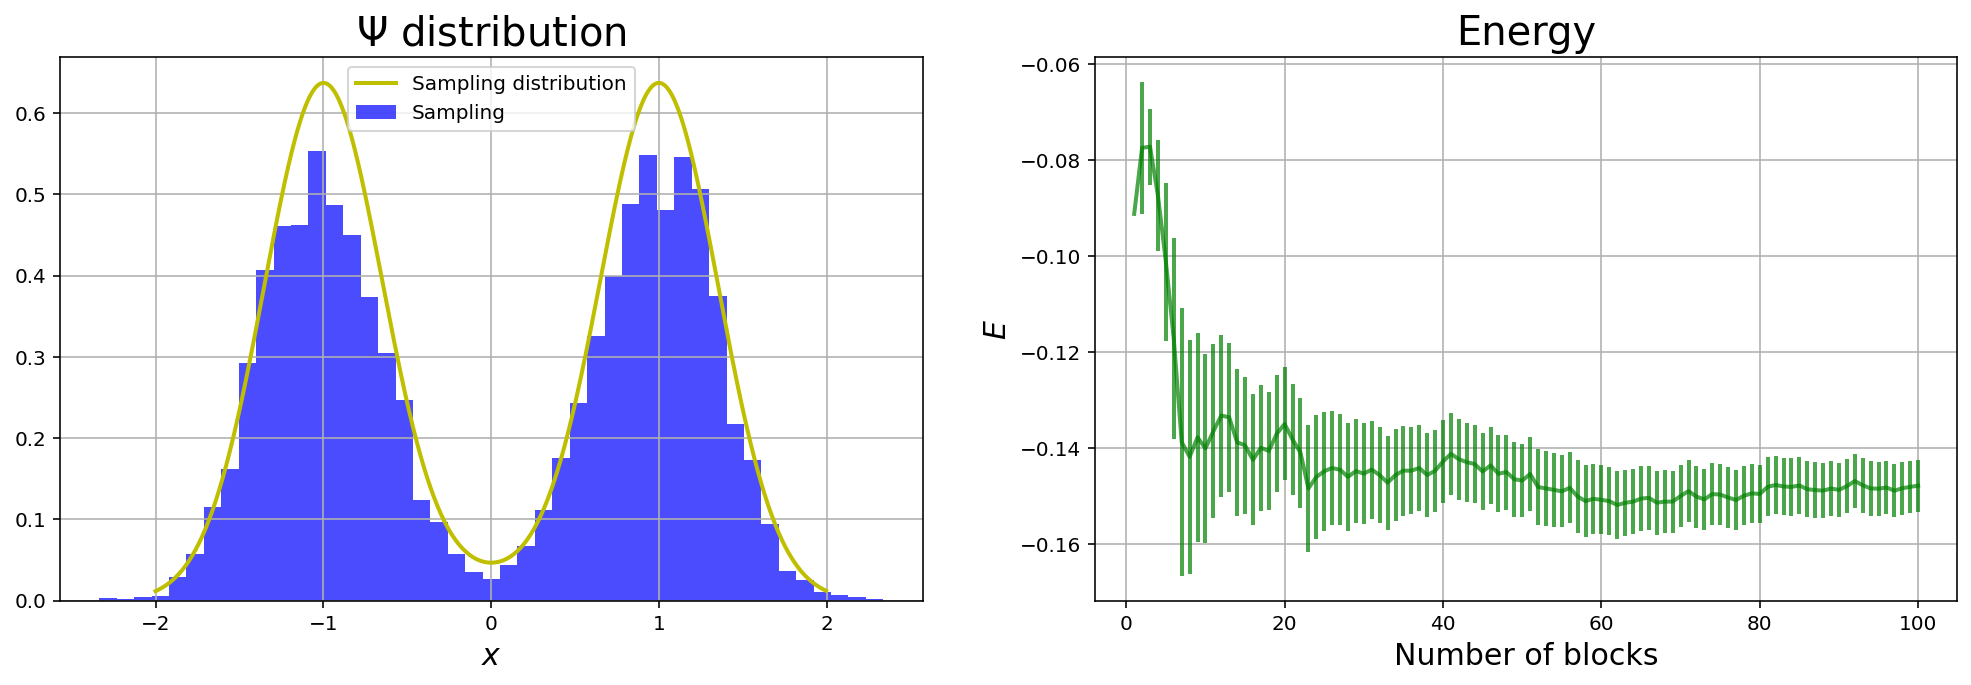

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import math

%config InlineBackend.figure_format='retina'

def psi_best(x, mu, sigma):
    return 1./(math.sqrt(2*math.pi)*sigma)*(math.exp((-(x-mu)**2)/(2*sigma**2))+
                                              +math.exp((-(x+mu)**2)/(2*sigma**2)))

x = np.loadtxt('Esercizio 8/data/sampling.dat')
blk, ene, sigma_ene = np.loadtxt("Esercizio 8/data/data.dat", dtype=float, usecols=(0,1,2), unpack='true')

n_bins = 45

z = np.arange(-2,2,0.005)
y = np.zeros(z.size)
i=0
for z1 in z:
    y[i] = psi_best(z1,1,0.5)**2
    i+=1

fig, ax = plt.subplots(1,2, figsize = (17,5))
ax[0].hist(x, bins=n_bins, color='b', alpha=0.7, density=True, label='Sampling')
ax[0].plot(z,y, color='y', label='Sampling distribution', linewidth=2)
ax[0].set_title(r'$\Psi$ distribution', size=20)
ax[0].set_xlabel('$x$', size=15)
ax[0].grid()
ax[0].legend(fontsize=10)
ax[1].errorbar(blk, ene, yerr=sigma_ene, color='g', alpha=0.7, linewidth=2)
ax[1].set_title('Energy', size=20)
ax[1].set_xlabel('Number of blocks', size=15)
ax[1].set_ylabel('$E$', size=15)
ax[1].grid()

Come è possibile osservare nell'immagine di sinistra, il campionamento della posizione $x$ avviene correttamente: vediamo due gaussiane centrate in $\mu = 1$ e $\mu = -1$. Per quanto riguarda i valori dell'energia vediamo che anch'essi si assestano attorno a $\langle H \rangle_{T} = -0.147 \pm 0.005$. Vedremo che questa funzione d'onda non è quella che minimizza l'energia, il che significa che non è quella ottimale. 

In questo caso è riportata la media e l'incertezza ottenuta tramite data blocking. Osserviamo che oltre un numero di $90$ blocchi l'errore statistico si riduce di poco e per questo nel seguito di questa presentazione calcoleremo i valori medi sempre su $100$ blocchi. 

### Esercizio 08.2

In questo esercizio vogliamo sfruttare il metodo del *Simulated Annealing (SA)* per ottimizzare i parametri $\mu$ e $\sigma$ che definiscono la $\Psi_{T}$. A partire da un valore iniziale dei parametri, viene calcolata la rispettiva energia media $E_{old}$. Dopodiché viene proposto un nuovo valore per ogni parametro e calcolata nuovamente l'energia media $E_{new}$. A questo punto definiamo una funzione costo, $C(\mu,\sigma) = E_{new} - E_{old}$. Accettiamo i nuovi parametri con probabilità $P = e^{-\beta C(\mu,\sigma)}$. In questo modo, se $E_{new} < E_{old}$ la proposta viene sicuramente accettata, altrimenti a volte viene accettata, a volte no. Ciò permette al sistema di andare verso i minimi locali dell'energia nello spazio dei parametri, e chiaramente, più $\beta$ è grande, più tale spazio viene esplorato. Dato che $\beta = \frac{1}{T}$, possiamo allora dire che abbassando la temperatura $T$ del sistema, questo tenderà sempre più a rimanere vincolato nei minimi locali dell'energia. Fondamentale, tuttavia è la stocasticità del processo che permette, qualora il sistema si ritrovi in un minimo locale, di avere probabilità non nulla di spostarsi verso un minimo assoluto.

Il codice che abbiamo scritto implementa appunto questo algoritmo.
1. Viene fissata una temperatura e calcolato il $\beta$.
2. Viene fatto uno step in maniera casuale nello spazio dei parametri e si calcola l'energia media (tramite data blocking su $10^{5}$ valori divisi in $100$ blocchi).
3. I nuovi valori dei parametri vengono accettati con probabilità $P = e^{-\beta(E_{new} - E_{old})}$.
4. Viene abbassata la temperatura e si ripete il ciclo fino a $T=0.001$

La temperatura deve decrescere lentamente, altrimenti avrei un effetto di congelamento del sistema in un minimo locale e non riuscirei più a raggiungere il massimo assoluto. Per questo la variazione di temperatura avviene nel seguente modo:
$$
T_{new} = T_{old}\times0.9995
$$

Nei risultati che stiamo per presentare abbiamo settato i parametri così:
- $\mu_{0} = 1.0$
- $\sigma_{0} = 0.5$
- $T_{0} = 2.0$

Inoltre, quando il sistema raggiunge un livello di energia sufficientemente basso diminuiamo l'ampiezza del passo nello spazio dei parametri, in particolare:
- $E > -0.45$:  $\Delta \mu = 0.01$,   $\Delta \sigma = 0.005$
- $E < -0.45$:  $\Delta \mu = 0.005$,  $\Delta \sigma = 0.001$

Questi parametri sono stati scelti guardando diverse realizzazioni dell'annealing e individuando una regione in cui si è ritenuto esserci il minimo assoluto.

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f86fa74dc70>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f86fa75d280>)

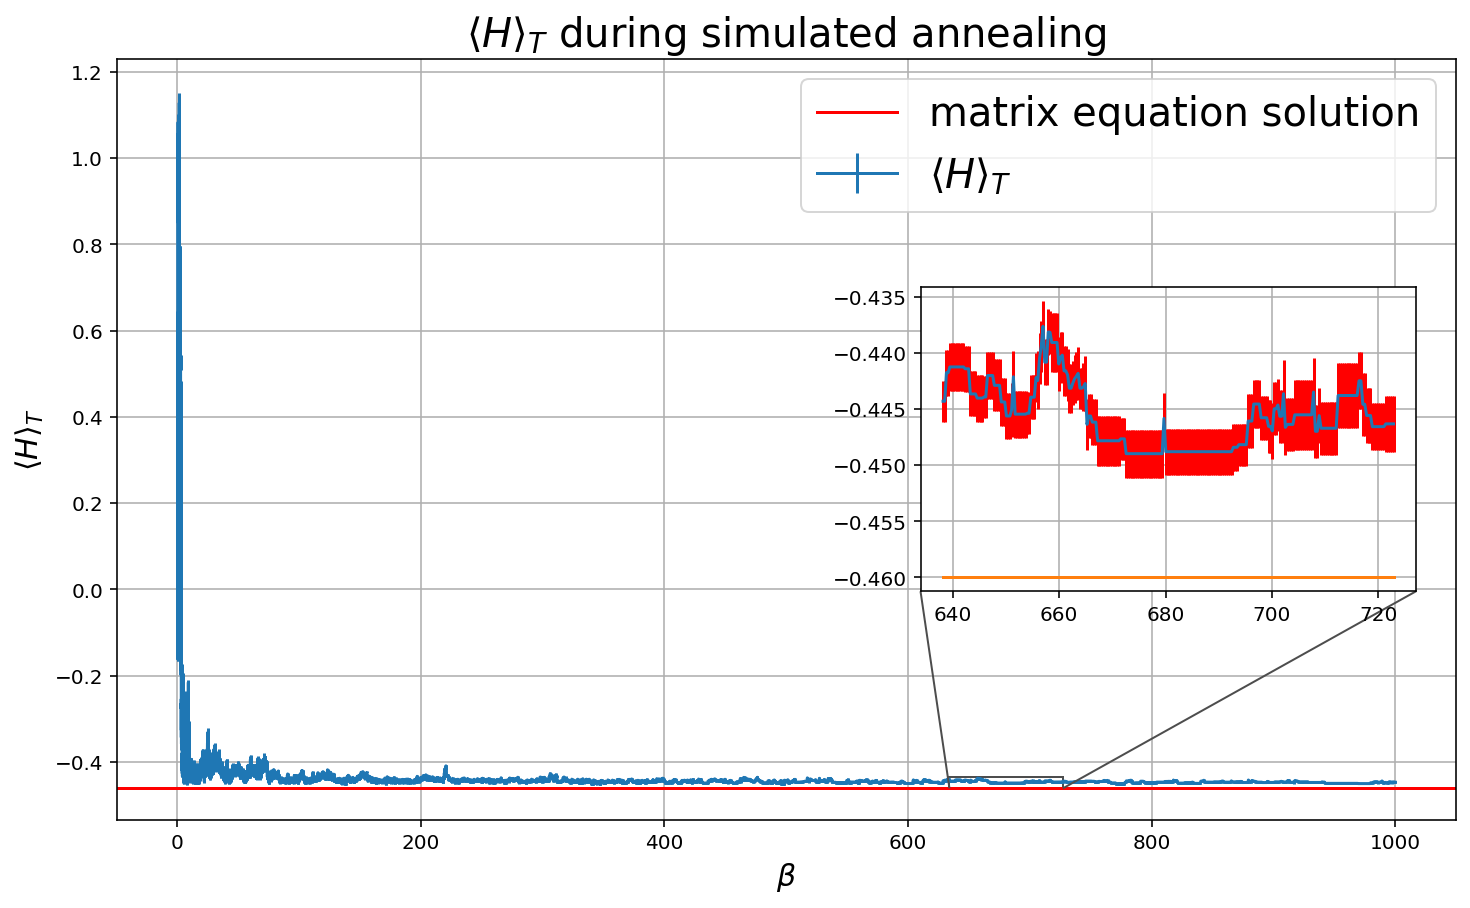

In [2]:
step, temp, mu, sigma, energy, sigma_energy = np.loadtxt("Esercizio 8/data/annealing.dat", usecols = (0,1,2,3,4,5), delimiter =' ', unpack = 'true')

beta = 1/temp
fig, ax = plt.subplots(figsize = (12,7))
ax.errorbar(beta, energy, yerr=sigma_energy, label=r'$\langle H \rangle_{T}$')
ax.axhline(-0.46, color = 'red', label='matrix equation solution')
ax.set_title(r'$\langle H \rangle_{T}$ during simulated annealing', size=20)
ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'$\langle H \rangle_{T}$', size=15)
ax.legend(fontsize=20)
ax.grid()

y=np.zeros((2,beta.size))
y[0]=beta
y[1]=-0.46

axins=ax.inset_axes([0.6,0.3,0.37,0.4])
axins.errorbar(beta[14300:14550],energy[14300:14550], yerr=sigma_energy[14300:14550], ecolor='r')
axins.plot(y[0][14300:14550],y[1][14300:14550])
axins.grid()
mark_inset(ax, axins, loc1=3, loc2=4, ec='0.3')

Nel grafico sopra riportato mostriamo l'andamento dell'energia man mano che viene abbassata la temperatura nel sistema, ovvero al **crescere di $\beta$**. Si osservano grandi fluttuazioni a temperatura alta, dovuto al fatto che il sistema si muove nello spazio dei parametri. Raffreddandolo, esso si trova chiuso nei minimi locali. Osservando l'ingrandimento riportato si noti come in questa regione il sistema si stabilisca nei minimi dell'energia; ciononostante, il carattere stocastico dell'algoritmo gli permette di fare salti in zone ad energie più alte per poi ricadere di nuovo nel minimo.

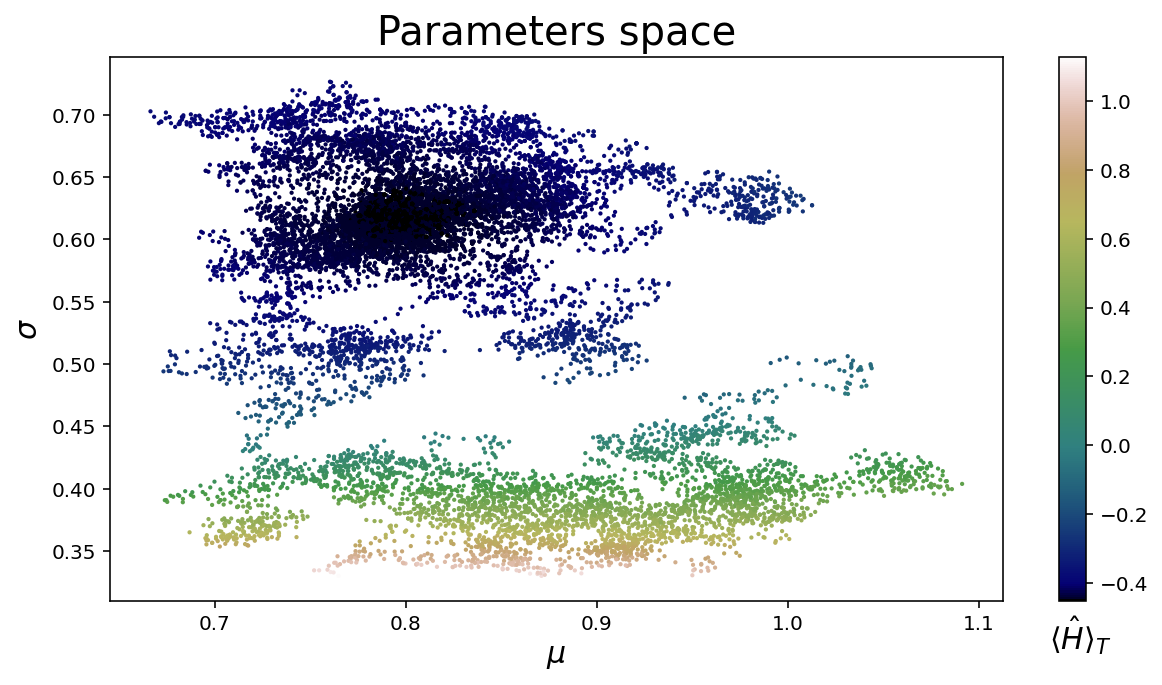

In [3]:
fig = plt.figure(figsize=(10,5))
cmap = cm.get_cmap('gist_earth')
ax = plt.scatter(mu,sigma, c=energy,cmap=cmap, marker='.', s=5)
plt.xlabel(r'$\mu$', fontsize=15)
plt.ylabel(r'$\sigma$', fontsize=15)
plt.title('Parameters space', size=20)
clb = plt.colorbar(ax,orientation='vertical')
clb.set_label(r'$\langle {\hat H} \rangle_T$', labelpad=-34, y=-0.025, rotation=0, fontsize=15)

In figura abbiamo riportato lo spazio dei parametri $\mu$ e $\sigma$. È molto interessante osservare come nelle zone ad alta energia siano presenti meno punti, mentre in quelle a energia più bassa la densità di punti aumenta, in quanto il sistema vi rimane intrappolato.

Alla fine del processo abbiamo ricavato i seguenti parametri che ottimizzano il problema:
- $\mu = 0.802$
- $\sigma = 0.616$

Fissati i parametri, riportiamo di seguito il calcolo dell'energia media e le medie progressive ottenute su $10^{5}$ dati divisi in $100$ blocchi.

In [4]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

Ground state energy:  -0.46046587969271546
1st excited state energy:  0.09742471331761056
2nd excited state energy:  1.9717331343930202


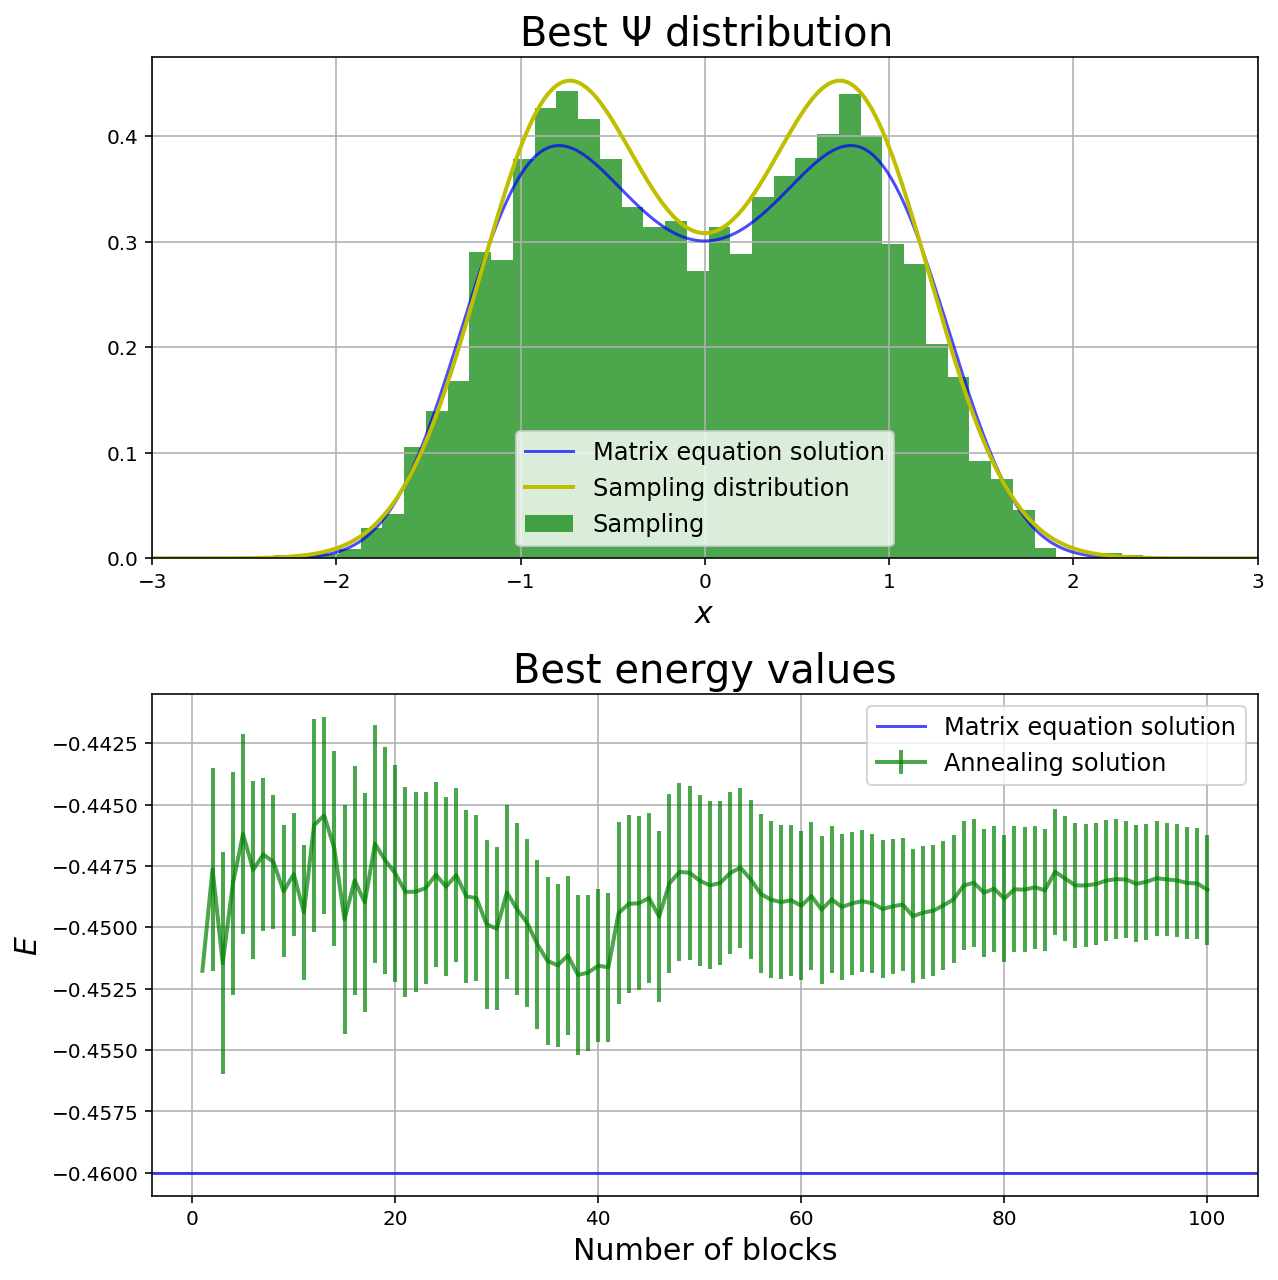

In [5]:
blk, ene, sigma_ene = np.loadtxt("Esercizio 8/data/best_data.dat", dtype=float, usecols=(0,1,2), unpack='true')
camp = np.loadtxt('Esercizio 8/data/best_sampling.dat')
n_bins = 40

z = np.arange(-6,6,0.005)
y = np.zeros(z.size)
i=0
for z1 in z:
    y[i] = psi_best(z1,0.802,0.616)**2
    i+=1

fig, ax = plt.subplots(2,1, figsize = (9,9))
ax[0].hist(camp, bins=n_bins, color='g', alpha=0.7, density = True,label='Sampling')
ax[0].plot(x,psi[0]**2, color='b', alpha=0.7, label='Matrix equation solution')
ax[0].plot(z,y, color='y', linewidth=2,label='Sampling distribution')
ax[0].set_xlim(-3,3)
ax[0].set_title(r'Best $\Psi$ distribution', size=20)
ax[0].set_xlabel('$x$', size=15)
ax[0].grid()
ax[0].legend(fontsize=12)
ax[1].errorbar(blk, ene, yerr=sigma_ene, color='g', alpha=0.7, linewidth=2, label='Annealing solution')
ax[1].axhline(-0.46, color = 'b', alpha=0.7,label='Matrix equation solution')
ax[1].set_title('Best energy values', size=20)
ax[1].set_xlabel('Number of blocks', size=15)
ax[1].set_ylabel('$E$', size=15)
ax[1].grid()
ax[1].legend(fontsize=12)

fig.tight_layout()

In conclusione osserviamo che il codice da noi implementato è in grado di avvicinarsi alla soluzione ottimale trovata tramite la *matrix equation*, soprattutto per quanto riguarda il valor medio $\mu$. Per quanto riguarda la varianza $\sigma^{2}$, la discrepanza è maggiore, come si può ben osservare dall'istogramma riportato. Ciò comporta anche lo scostamento tra il valore medio dell'energia ricavato con i due metodi.

### <span style="color:green">Supplementary material</span>

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.